# Обработка MSI данных
**Данные в imzml не должны быть центроидными**

В обработку MSI данных в данном пакете входят следующие шаги в порядке их применения:
1) Resample данных. Используется в основном для приведения данных к равномерной шкале между точками по `mz` и/или приведения к общей шкале `mz`.
2) Выравнивание спектров относительно референсных пиков ([msalign](attachmnet:https://github.com/lukasz-migas/msalign)). msalign хуже работает на неконтинуальных данных, строго рекомендуется провести resample данных.
3) Корректировка базовой линии пакетом [pybaselines](attachmnet:https://pybaselines.readthedocs.io/)
4) Сглаживание. За основу взяты вырезки из кода [mMass](https://github.com/xxao/mMass). Cглаживание происходит по алгоритмам moving average, Гауссианой и Савицкого-Голея
5) Peak-picking

Все шаги опциональны. В случае записи неконтинуальных масс спектров в hdf5, необходим resample данных.

## Основные функции проведения обработки спектров MSI данных.
### Краткое описание
1) `draw_processing_example` - функция для подборки параметров обработки и получаемого пиклиста путём визуализации результатов. Обрабатывает один спектр из каждого roi. Функция необходима для предварительной оценки выбранных параметров обработки перед их применением на больших MSI данных.
2) `Raw2peaklist` - полный цикл обработки данных от imzml до получение пиклиста. Итоговый пиклист записывается в `HDF5`.
3) `Raw2proc` - Обработка спектров до сглаживания с последующей их записью в `HDF5`. 
4) `proc2peaklist` - peak-picking обработанных спектров, полученных после функции Raw2procc. Итоговый пиклист записывается в `HDF5`.

### Описание параметров функций
Функции выше имеют одни и те же параметры согласно шагам обработки:
- **Параметры шага resample**:
    - `resample_to_dots` - кол-во точек, на которое равномерно разбивается шкала mz. Значение `None` (default) - resample не производится  
- **Параметры выравнивания** на основе чуть адаптированного msalign:
    - `align_peaks` - список референсных пиков для выравнивания масс-спектров. В качестве референсных пиков рекомендуется использовать те, которые есть в каждом спектре. Значение `None` (default) - выравнивание не производится 
    - `weights_list`- список весов пиков. Значение `None` (default) - вес всех пиков одинаков и выравнивание производится относительно них - эквивалентно.
    - `max_shift_mz` - задание максимального сдвига при выравнивании. Позволяет избегать выбросы в размерах сдвига, особенно если в спектре не нашлось необходимого пика. Default - 0.95
    - `only_shift` - определяет производится ли только линейный сдвиг или и rescale интенсивностей относительно шкалы mz (шкала остаётся неизменной). Рекомендуется ставить `False` только если список референсных пиков покрывает весь диапазон. Значение `True` (Default) - только сдвиг.
    - `params2align` - дополнительные параметры функции msalign в виде словаря. Default - {}
- **Корректировка базовой линии** на основе пакета pybaselines:
    - `baseliner_algo` - алгоритм коррекции базовой линии ([алгоритмы](https://pybaselines.readthedocs.io/en/latest/algorithms/index.html)). Default - 'asls', 
    - `params2baseliner_algo` - параметры алгоритма, записанные в виде словаря (Параметры [алгоритма](https://pybaselines.readthedocs.io/en/latest/algorithms/index.html) можно найти в его описании). Default - {}
    
    Данные теста по времени расчётов разными алгоритмами:

<table style="display: inline-block">
<thead>
  <tr>
    <th>Baseline corr. </th>
    <th>time, sec </th>
    <th>std </th>
  </tr>
  </thead>
  <tbody>
  <tr><td>penalized_poly <td> 39.939660 <td>0.333161
  <tr><td>psalsa<td> 68.164038<td> 1.076445 
<tr><td>asls<td>74.820824<td> 2.491647 
<tr><td>modpoly<td> 90.877258<td> 0.404573 
<tr><td>imodpoly<td>92.366724<td> 1.480368 
<tr><td>pspline_asls<td> 109.931471<td> 2.996002 
<tr><td>pspline_arpls<td> 144.483299<td> 0.545680 
<tr><td>iasls<td> 151.794079<td>2.079635
<tr><td>pspline_drpls<td> 153.399234<td> 0.979653
<tr><td>derpsalsa<td> 158.482222<td> 2.174172
<tr><td>mixture_model<td> 160.452414<td> 1.122949   
<tr><td> mor<td> 251.438342<td> 0.157675 
<tr><td> tophat<td> 253.503103<td> 3.782560
<tr><td> mwmv<td> 253.705837<td> 1.883491
<tr><td> mpls<td> 263.834968<td>  0.594738
<tr><td> iarpls<td> 276.942958<td> 2.358620
<tr><td> arpls<td> 325.495197<td> 2.785515 
<tr><td> imor<td> 375.992667<td> 0.703071
<tr><td> jbcd<td> 379.899568<td> 2.547387
<tr><td> drpls<td> 558.671277<td> 29.941927
<tr><td> irsqr<td> 697.559541<td> 0.764044
<tr><td>quant_reg<td> 779.191954<td> 2.312255
<tr><td>mpspline<td> 1560.948403<td> 6.096026
<tr><td>goldindec <td> 1890.570998<td> 5.923874
<tr><td>aspls<td> 2130.725385<td>  31.169560
</td></tr>
 </tbody>
</table>


Самый быстрый - `penalized_poly`, но у данного алгоритма часто бывают отрицательные интенсивности у низкоинтенсивных пиков и при использовании фильтров во время обработки - эти пики сразу отсекаются. 
По этой причине самый оптимальный `asls`, у которого данная проблема провляется реже.
- **Сглаживание**:
    - `smooth_algo` - Типа алгоритма сглаживание: 
        - "MA" - Moving Average filter
        - "GA" - Gaussian filter
        - "SG" - savitzky-golay filter (Not implemented yet)
        - None - сглаживание не производится (Default)
    - `smooth_window` - размер окна для сглаживания в mz. Default: 0.075
    - `smooth_cycles` - кол-во циклов сглаживания. Default: 1
- **Peak-picking**:
    - `noise_est` - способ определения уровня шума: 
        - "std" - стандартное отклонение по всему "шумовому спектру" (это точки, которые не относятся ни к одному пику, признанным сигнальным) (Default)
        - "mad" - медианное абсолютное отклонение по всему "шумовому спектру" (Not recommended).
    - `noise_est_iterations` - кол-во итераций определения точек принадлежащих сигнальным пикам. Default: 3 
    - `SNR_threshold` - фильтр сигнальных пиков по отношению signal-to-noise ratio. Default: 3.5
    - `oversegmentationfilter` - фильтр близких сигнальных пиков друг к другу. Default: 0 
    - `peaklocation` - параметр работает в связке с `oversegmentationfilter`. Определяет зону поиска предполагаемого положения пика вне дискретности шкалы mz, для вероятного более точного определения дистанции между соседними пиками. Default: 1. 
    - `fwhhfilter` - фильтр по полуширине пика. Если значение одно число, то удаляются все пики с FWHM меньше этого значения, если кортеж, сохраняет пики с значением fwhm, находящимся в этом диапазоне.  Default: 0
    - `heightfilter` и `rel_heightfilter` - фильтры по абсолютной и относительной высоте пиков. Относительная высота пиков должна быть от 0 до 1 и определяется для каждого спектра индивидуально относительно максимальной интенсивности пика в спектре. Default: 0


## Examples
### Подбор оптимальных параметров обработки с помощью `draw_processing_example`
#### Дополнительные параметры функции:
- `data_obj_path` - задать путь к папке/файлу. Можно несколько путей списком: [path_1, path_2].
    - Если нужно работать только с одним файлом в указанном пути, то лучше указать прямой путь к нему (example: *r"D:\Testing\Metabolights\MTBLS176\3DMouseKidney.imzML"*).
    - Если необходимо выгрузить сразу несколько файлов, указав один путь, то можно указать путь к общей папке (example: *r"D:\Testing\Metabolights"* или если имеется несколько файлов "imzml" в одной папке, то сработает и путь *r"D:\Testing\Metabolights\MTBLS176*).
- `mz_diap4draw` - с помощью кортежа указать нижний и верхний предел отрисовки графика, где будем оценивать результат обработки
- `spec_num` - номер спектра для визуальной проверки. Если `None`, то ставит случайный спектр

#### Пример подбора оптимальных параметров обработки для континуальных данных TOF анализатора.

c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First iteration


c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


Spectrum number: 4200


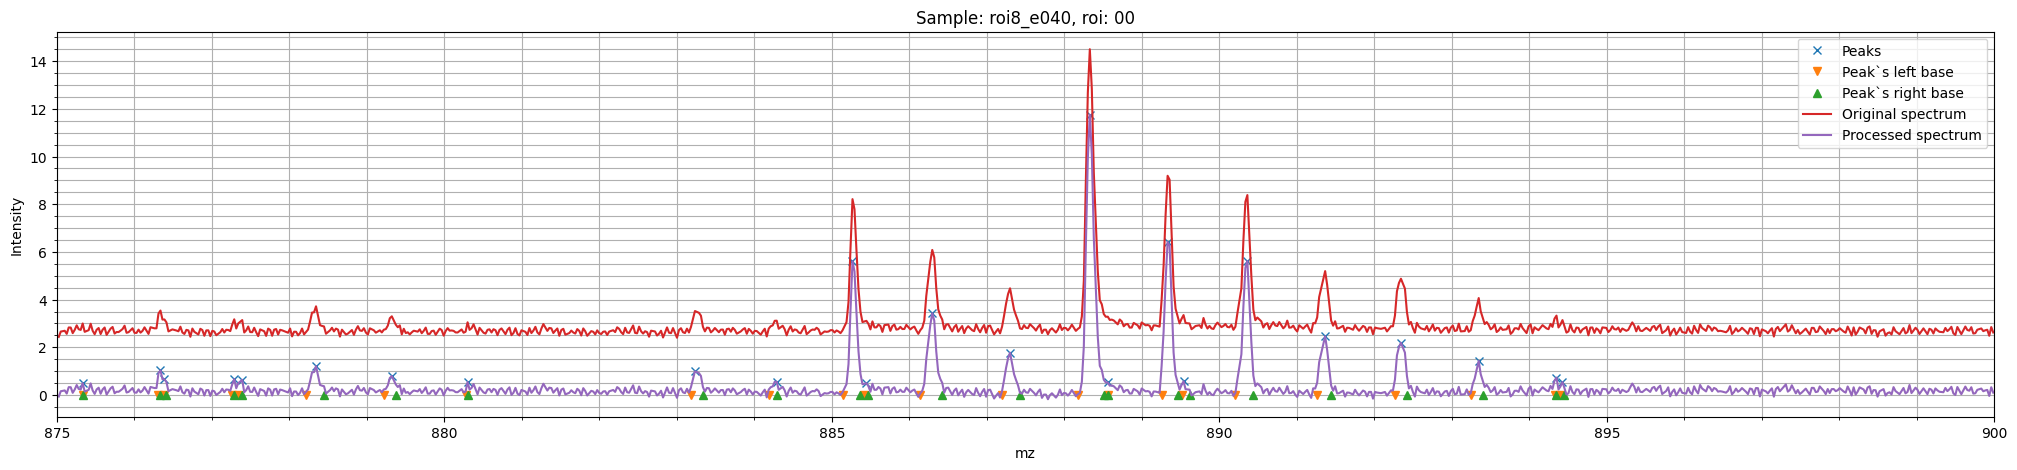

Second iteration. SNR filter is 3.5, and oversegmentationfilter is 0.15


c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


Spectrum number: 4200


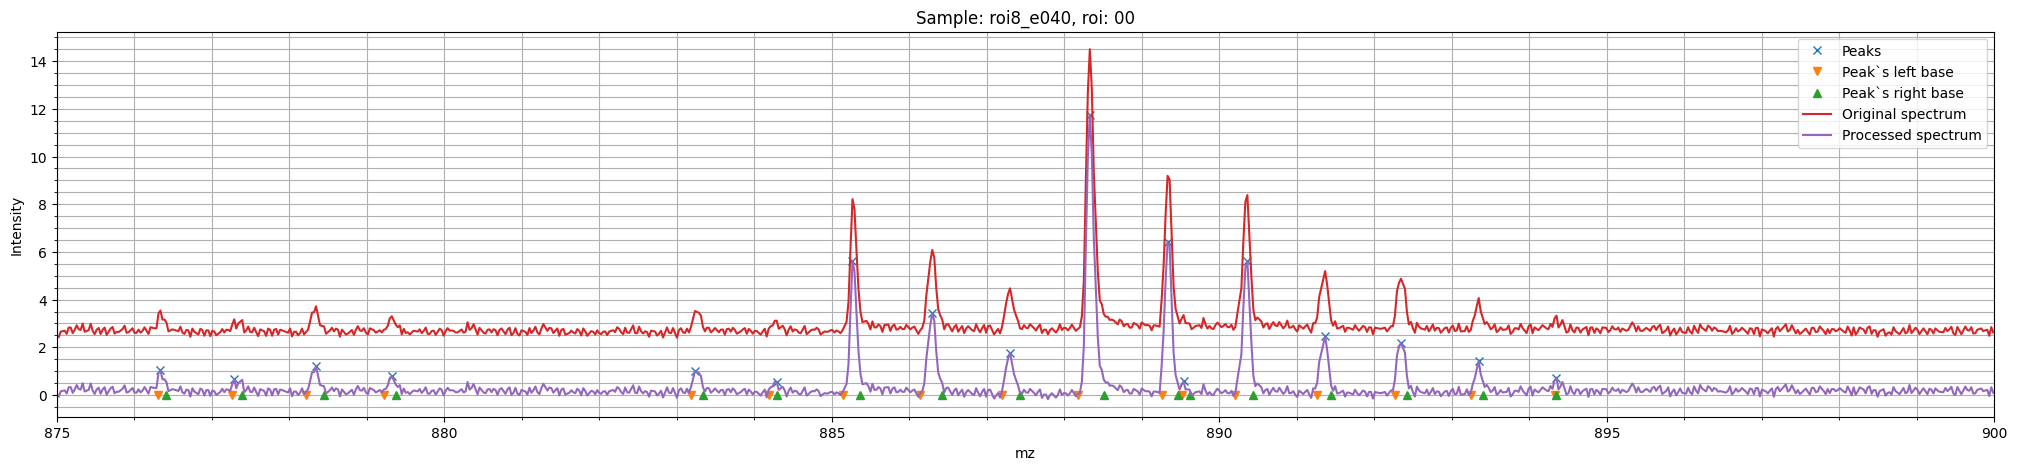

Third iteration. Data is resampled and smoothed


c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


Spectrum number: 4200


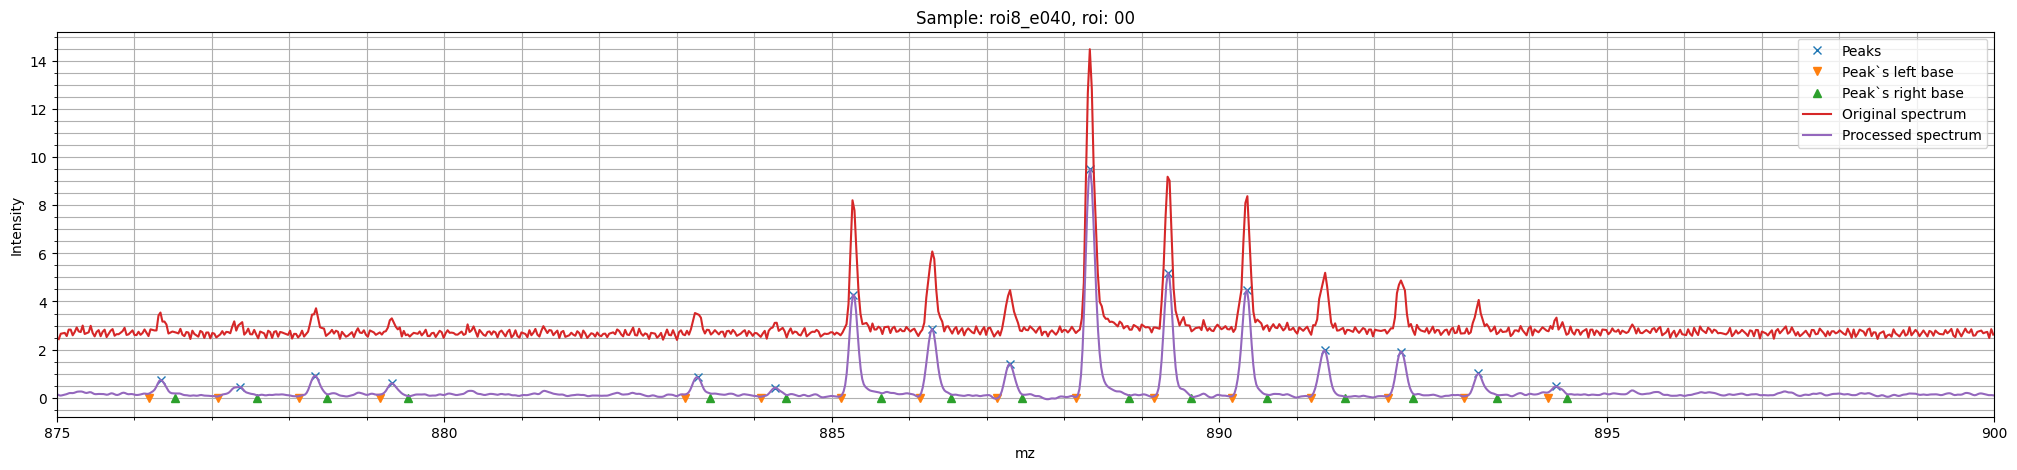

In [1]:
from ProcceMSI.pspectra import draw_processing_example
# Path to imzml file
path = r"D:\Testing\Our_data\Rapiflex\roi8_e040"
# Func args
diap = (875,900)
num = 4200
snr = 3.5
oversegfil= 0.15
print('First iteration')
draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,SNR_threshold=3)
print(f'Second iteration. SNR filter is {snr}, and oversegmentationfilter is {oversegfil}')
draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,SNR_threshold=snr, oversegmentationfilter=oversegfil)
print('Third iteration. Data is resampled and smoothed')
draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,SNR_threshold=snr, oversegmentationfilter=oversegfil,resample_to_dots=50000,smooth_algo='GA',smooth_window=0.2)

#### Пример подбора оптимальных параметров обработки для неконтинуальных данных Orbitrap анализатора.
<div class="alert alert-block alert-warning">
С неконтинуальными данными орбитрепа имеются особенности обработки при выравнивании спектров по референсным пикам. Данная проблема предствлена ниже и является результатом неравномерности расположения точек на спектре и решается ресемплом данных.</div>

First iteration with alignment and without spectra resampling
Spectrum number: 2542


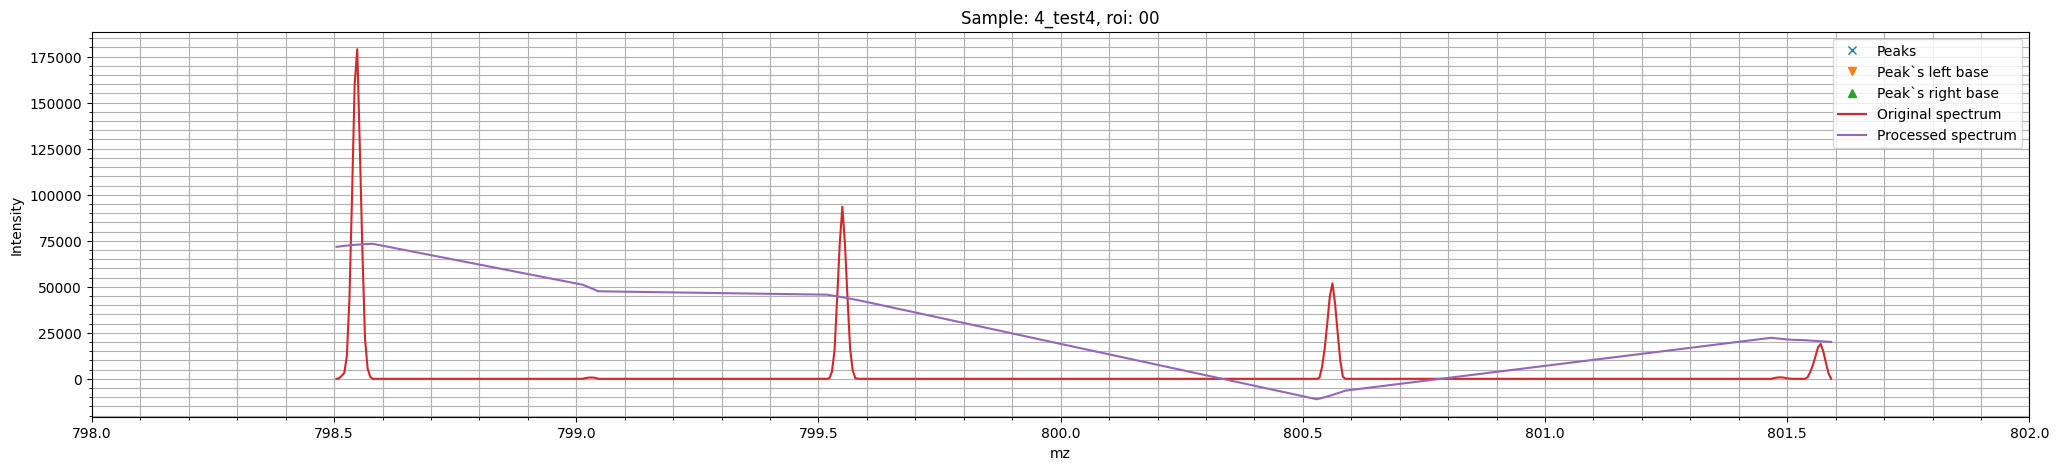

Second iteration. Added spectra resampling with 50000 dots
Spectrum number: 2542


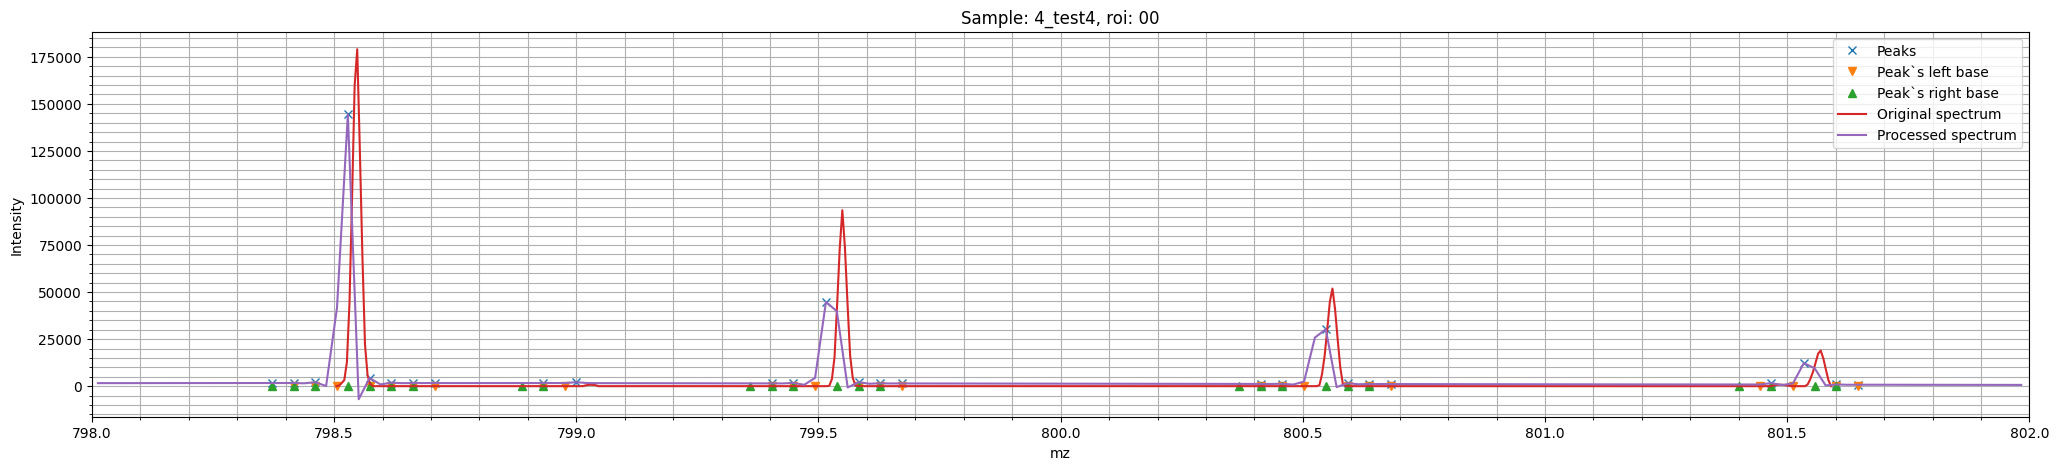

Third iteration. Resampling with 300000 dots
Spectrum number: 2542


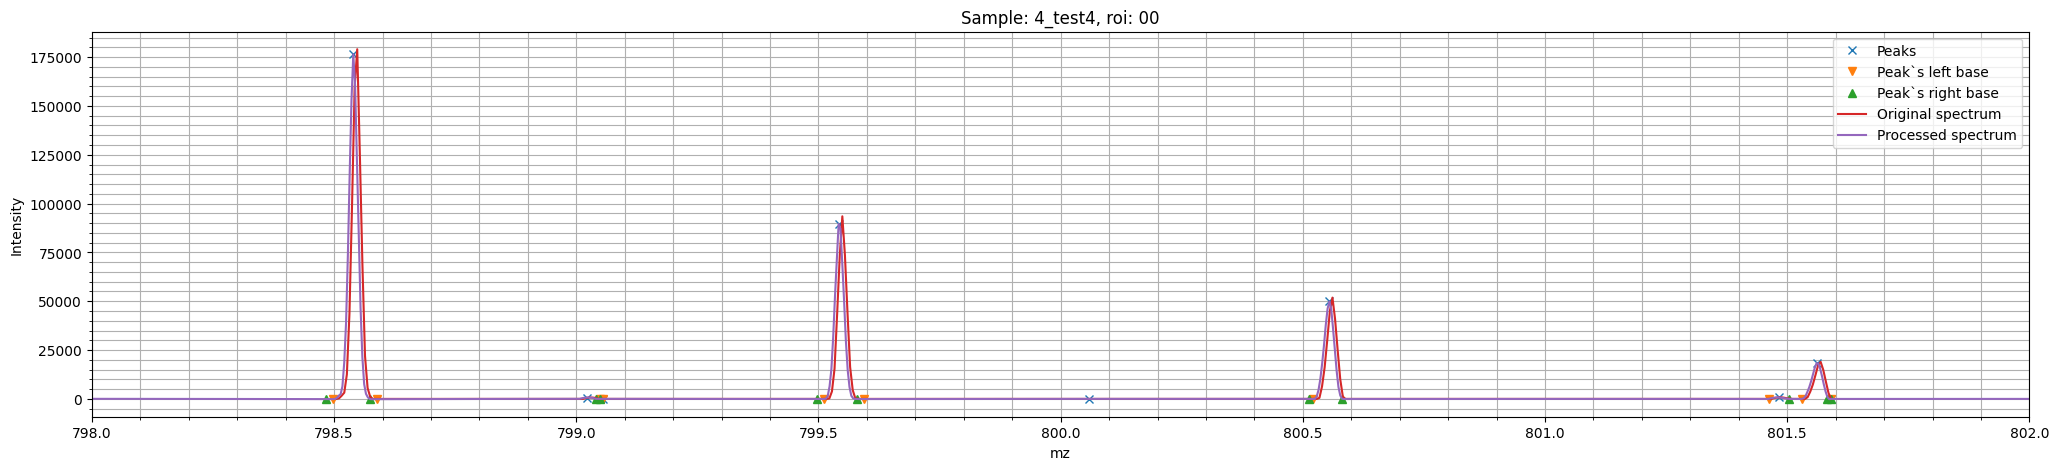

Fourth iteration. Adjusted peak picking
Spectrum number: 2542


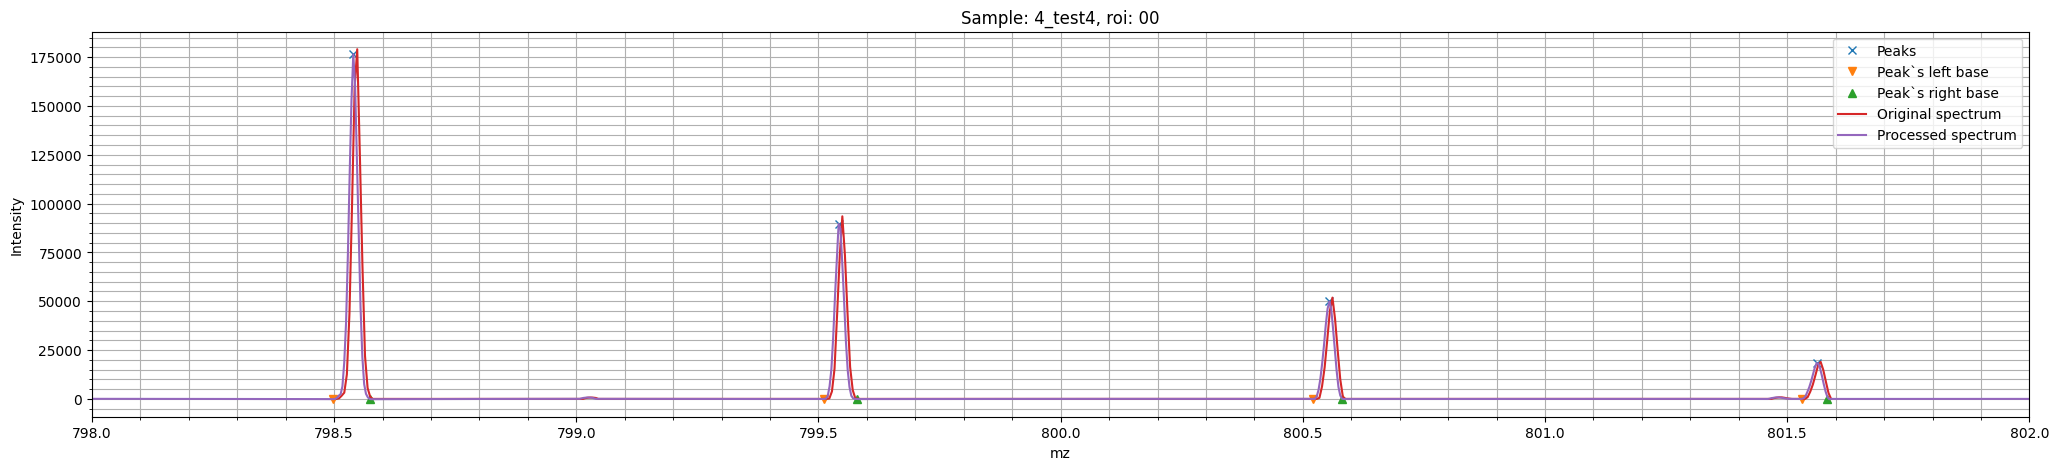

In [2]:
from ProcceMSI.pspectra import draw_processing_example
import warnings # Используем только для отключения предупреждений


with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Используем только для отключения предупреждений
    # Path to imzml file
    path = r"D:\Testing\Our_data\Orbitrap\4"
    # Func args
    diap = (798,802)
    refpeaks_list = [798.5408,769.4779,769.5620,773.5092,496.3397]
    num = 2542 # spectrum number

    print('First iteration with alignment and without spectra resampling')
    draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,align_peaks=refpeaks_list,only_shift=False)
    print(f'Second iteration. Added spectra resampling with 50000 dots')
    draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,align_peaks=refpeaks_list,only_shift=False,SNR_threshold=3,resample_to_dots=50000)
    print('Third iteration. Resampling with 300000 dots')
    draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,align_peaks=refpeaks_list,only_shift=False,SNR_threshold=3,resample_to_dots=300000)
    print('Fourth iteration. Adjusted peak picking')
    draw_processing_example(data_obj_path=path,spec_num=num,mz_diap4draw=diap,align_peaks=refpeaks_list,only_shift=False,SNR_threshold=9,resample_to_dots=300000)

## Примеры обработки MSI данных.
### Получение пиклистов имаджа функцией `Raw2peaklist`.
Данный вариант обработки MSI данных проводится без промежуточной записи обработанных масс-спектров и записываются в файл `hdf5` только пиклисты.

**Pros:**
- Работает и с континуальными и неконтинуальными данными с любой обработкой.
- Занимает значительно меньше места на жёстком диске.

**Cons:**
- Иногда обработка занимает больше времени.

##### **Дополнительные параметры функции**:
- `data_obj_path` - путь к папке/файлу `imzml`. Возможно задать сразу несколько путей списком: [path_1, path_2].
    - Если нужно работать только с одним файлом в указанном пути, то лучше указать прямой путь к нему (example: *r"D:\Testing\Metabolights\MTBLS176\3DMouseKidney.imzML"*).
    - Если необходимо выгрузить сразу несколько файлов, указав один путь, то можно указать путь к общей папке (example: *r"D:\Testing\Metabolights"* или если имеется несколько файлов "imzml" в одной папке, то сработает и путь *r"D:\Testing\Metabolights\MTBLS176*).
- `mz_diap4draw` - с помощью кортежа указать нижний и верхний предел отрисовки графика, где будем оценивать результат обработки
- `draw` - Если True (default), то строит график результатов обработки случайного масс-спектра от каждого имаджа для визуальной оценки.
-  `Ram_GB` - ориентировочное максимальное задействование оперативной памяти при обработке в Гб (Default - 1). Определяет на сколько батчей разбиваются все данные.
- `h5chunk_size_MB` - задаёт размер разбивки матрицы пиклистов записываемой в `hdf5` для частичной подгрузки данных на основе размера в Мб (default: 10)
- `dtypeconv` - формат записываемых данных `double`, `single` и `half` (not recommended). Позволяет уменьшить занимаемое место датасетов пиклистов на жёстком диске, в ущерб точности знаков после запятой.
- `free_cores` - кол-во ядер ЦПУ, неиспользуемых при рассчётах

Получим пиклисты наших данных с использованием подобранных ранее настроек обработки 

The Rapiflex raw spectra data is on progress.
Slide's Rapiflex spectra coordinates and metadata extraction for preparation parallel proccessing
Slide's Rapiflex spectra coordinates writing
Slide's Rapiflex spectra parallel proccessing


Batches progress: 100%|██████████| 38/38 [04:51<00:00,  7.40s/it]  c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


Spectrum number: 885


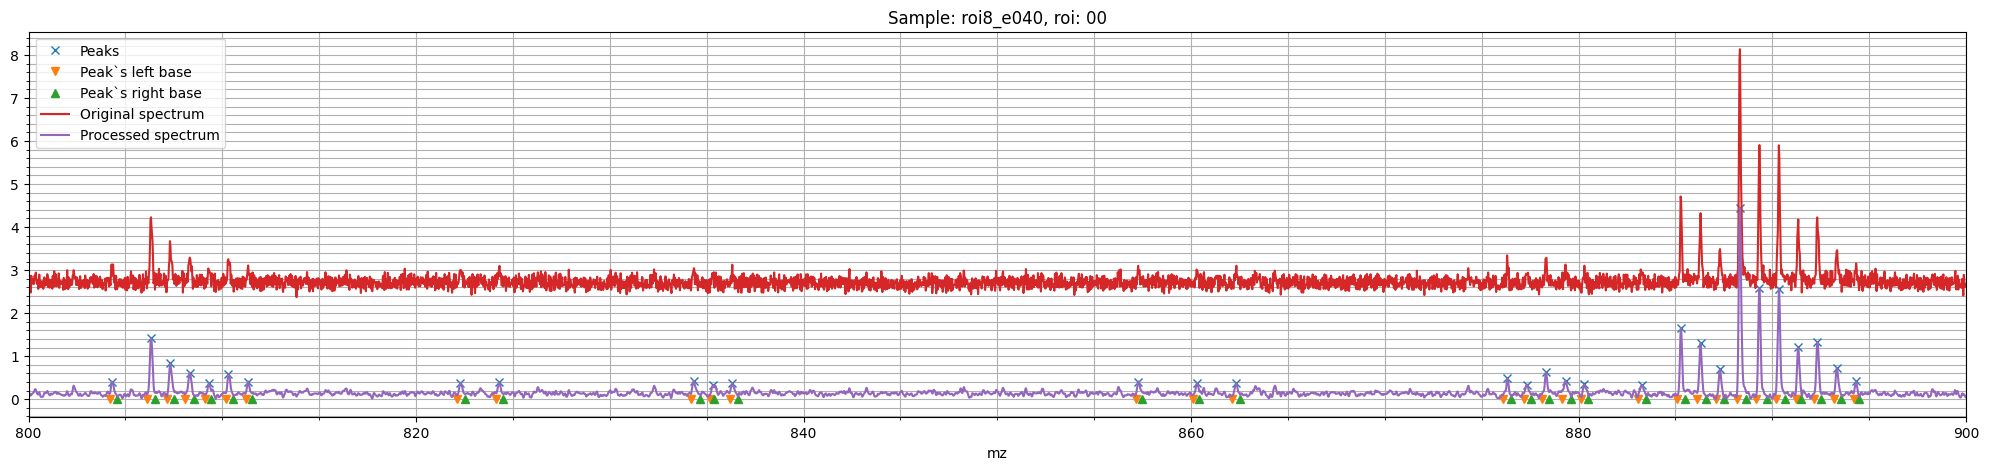

Batches progress: 100%|██████████| 38/38 [04:54<00:00,  7.74s/it]
c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


In [3]:
from ProcceMSI.pspectra import Raw2peaklist
path = r"D:\Testing\Our_data\Rapiflex\roi8_e040\roi8_e040.imzML"

Raw2peaklist(path, mz_diap4draw=(800,900), oversegmentationfilter=0.15,SNR_threshold=3.5,resample_to_dots=50000,smooth_algo='GA',smooth_window=0.2,Ram_GB = 10)

### Получение обработанных масс-спектров имаджа функцией `Raw2proc` и из этих же данных пиклисты функцией `proc2peaklist`.
Данный вариант обработки MSI данных делает только обработку спектров от выгрузки из `imzml` до сглаживания и сохраняет их в `hdf5`.

**Pros:**
- Использование обработанных масс-спектров для других вариантов подготовки и исследований.

**Cons:**
- Требует большого кол-ва места на жёстком диске.
- Нет возможности работы и сохранения неконтинуальных данных без ресемплинга.

##### **Дополнительные параметры функций**:
- `data_obj_path` - путь к папке/файлу `imzml` для функции `Raw2proc` или `hdf5` для функции `proc2peaklist`. Возможно задать сразу несколько путей списком: [path_1, path_2].
    - Если нужно работать только с одним файлом в указанном пути, то лучше указать прямой путь к нему (example: *r"D:\Testing\Metabolights\MTBLS176\3DMouseKidney.imzML"*).
    - Если необходимо выгрузить сразу несколько файлов, указав один путь, то можно указать путь к общей папке (example: *r"D:\Testing\Metabolights"* или если имеется несколько файлов "imzml" в одной папке, то сработает и путь *r"D:\Testing\Metabolights\MTBLS176*).
- `mz_diap4draw` - с помощью кортежа указать нижний и верхний предел отрисовки графика, где будем оценивать результат обработки
- `draw` - Если True (default), то строит график случайного масс-спектра от каждого имаджа до и после обработки для визуальной оценки обработки.
-  `Ram_GB` - ориентировочное максимальное задействование оперативной памяти при обработке в Гб (Default - 1). Определяет на сколько батчей разбиваются все данные.
- `h5chunk_size_MB` - задаёт размер разбивки матрицы пиклистов записываемой hdf5 для частичной подгрузки данных на основе размера в Мб (default: 10)
- `dtypeconv` - формат записываемых данных `double`, `single` и `half` (not recommended). Позволяет уменьшить занимаемое место датасетов масс-спектров на жёстком диске.
- `free_cores` - кол-во ядер ЦПУ, неиспользуемых при рассчётах

Получим обработанные масс-спектры с использованием подобранных ранее настроек обработки и после отдельно проведём пик-пикинг. 

The Rapiflex raw spectra data is on progress.
Slide's Rapiflex spectra coordinates and metadata extraction for preparation parallel proccessing
Slide's Rapiflex spectra parallel proccessing


Batches progress: 100%|██████████| 38/38 [02:46<00:00,  4.23s/it]

Slide's Rapiflex spectra drawing results
Spectrum number: 20543


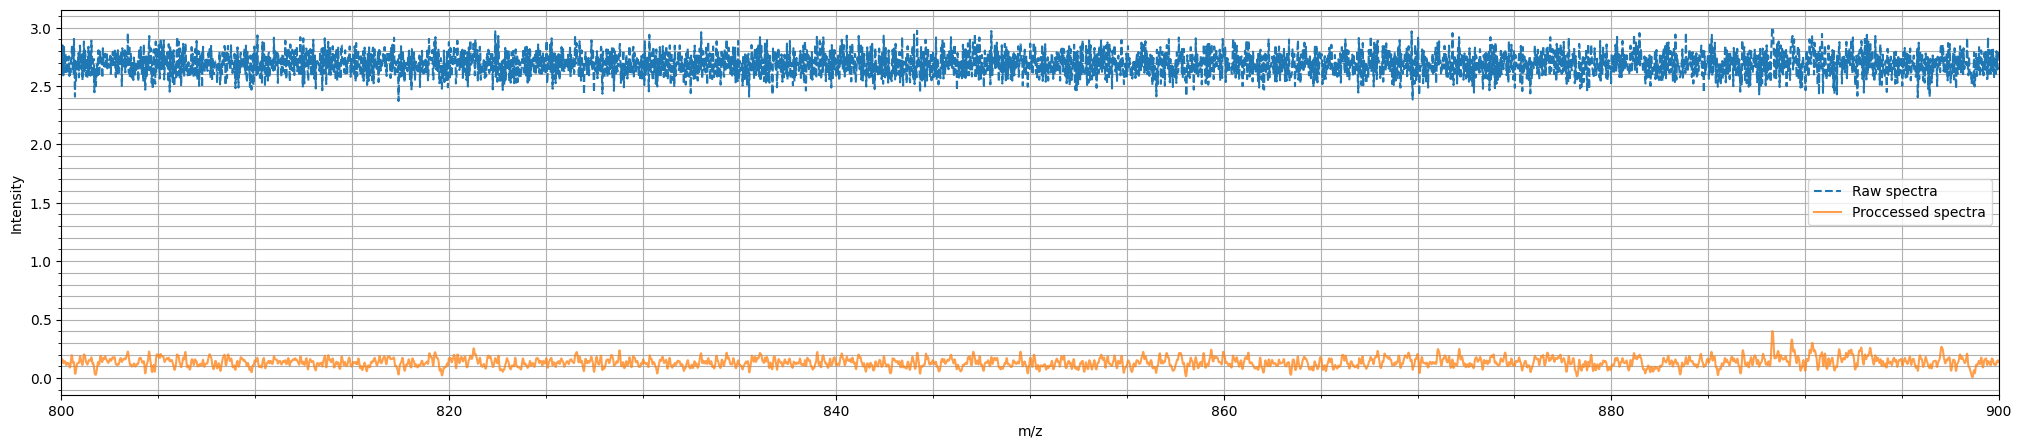

Batches progress: 100%|██████████| 38/38 [02:49<00:00,  4.46s/it]


The Rapiflex processed spectra data is loaded from the hdf5 file.
Slide's Rapiflex spectra parallel peak picking


Batches progress: 100%|██████████| 424/424 [05:04<00:00,  1.51it/s]

Slide's Rapiflex spectra writing feature results
Spectrum number: 16798


c:\Users\Kuzya\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


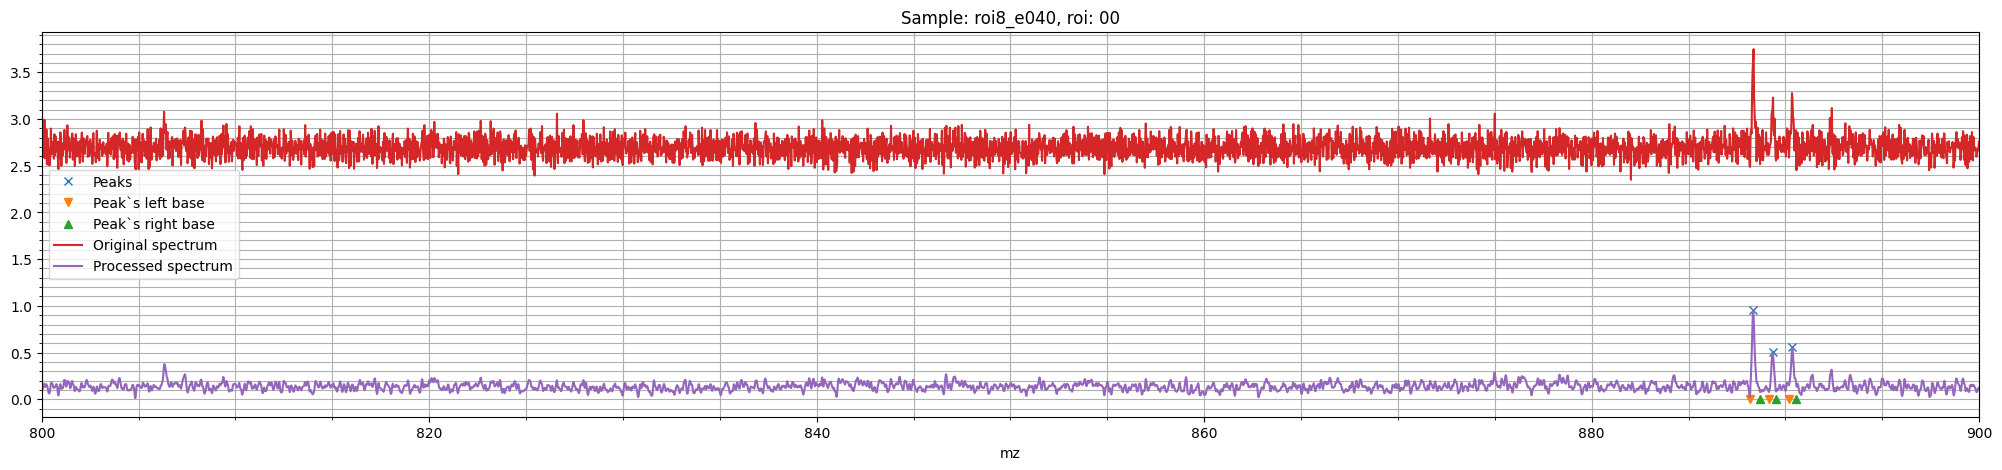

Batches progress: 100%|██████████| 424/424 [05:08<00:00,  1.38it/s]


In [4]:
from ProcceMSI.pspectra import Raw2proc,proc2peaklist
path = r"D:\Testing\Our_data\Rapiflex\roi8_e040\roi8_e040.imzML"

Raw2proc(path,resample_to_dots=50000,smooth_algo='GA',smooth_window=0.2, mz_diap4draw=(800,900),Ram_GB = 10)
path = r"D:\Testing\Our_data\Rapiflex"
proc2peaklist(path,oversegmentationfilter=0.15,SNR_threshold=3.5, mz_diap4draw=(800,900),Ram_GB = 10)

#### Расположение обработанных данных.
Данные от функций выше записываются в файл hdf5 с названием *"<folder_name>_specdata.hdf5"* и находятся в папке выше от местонахождения самого файла imzml. 
Например, если path - путь к файлу *r"D:\Testing\Our_data\Rapiflex\roi8_e040\roi8_e040.imzML""*, *r"D:\Testing\Our_data\Rapiflex\roi8_e040"* или *r"D:\Testing\Our_data\Rapiflex"*, то файл сохранится в *r"D:\Testing\Our_data\Rapiflex"*:

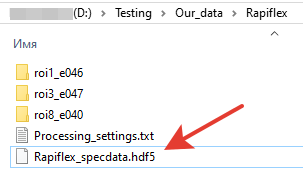

Если выгружаются сразу несколько файлов (example path: *r"D:\Testing\Our_data\Rapiflex"*), то все они будут храниться в одном файле *"<folder_name>_specdata.hdf5"* в папке выше от них (в примере выше в папке: Rapiflex - *"Rapiflex_specdata.hdf5"*).

Если указан путь ещё выше (вплоть до *"D:\ "*) (example path: *r"D:\Testing\Our_data" or r"D:\Testing"*), то функция найдёт все файлы imzml в подпапках и создаст несколько файлов "hdf5", в случае достаточно далеко отстоящих файлов согласно описанному выше.

#### Выгрузка обработанных данных
Выгрузка пиклистов и обработанных масс-спектров (после функции `Raw2proc`), производится функцией `specdata_Load` из модуля `loaders`.
В функцию подаётся параметр path, в который можно задать прямой путь к файлу `_specdata.hdf5` или к общей папке с другим файлом `_specdata.hdf5` и загрузить таким образом несколько файлов. Также можно задать список путей: [path_1, path_2].

Работа с обработанными данными основана на объекте из `hdf5py` пакета (https://docs.h5py.org/en/stable/). Для выгрузки данных используется стандартная для словарей индексация к датасету имаджа.

Пример пути к датасету: HDF5File[Slide][sample][roi][dataset], 

- где `Slide` - это группа датасетов из одного hdf5 файла.

- `sample` - это группа данных, в которую выгружены данные из одного imzml файла (название sample создаётся следующим образом: <_название корневой папки imzml_>_<_название файла imzml_>, если <_название корневой папки imzml_> идентично <_название файла imzml_>, то sample записывается без дублированного названия и '\_' между)

- `roi` - это группа данных, отвечающая за область измерения. В одном файле imzml может быть записано несколько областей с одного эксперимента (к примеру файлы от Rapiflex). Но для остальных приборов в основном там только одна область: "00"

- `dataset` - название записанных данных:
    - `mz` - одномерный вектор mz (1,N), где N - кол-во точек спектра. 
    - `int` - матрица интенсивностей (M,N), где каждая строка M - соответствует списку точек интенсивностей спектра, соответственно, в матрице записано M спектров, а N равно размеру- кол-во точек. 
    - `xy` - матрица координат (M,2), где каждая строка соответствует координатам спектра. 1-ая и 2-ая колонки - x и y координаты, соответственно.
    - `peaklists` - пиклист, где каждая строка - это характеристики пика

Индексация датасета согласно numpy.array, за исключением, если необходимо выгрузить весь датасет разом - необходимо добавить "[:]". Например:
* Выгрузить весь датасет: 
HDF5File[Slide][sample][roi][dataset][:]
* Выгрузить несколько спектров из датасета: 
HDF5File[Slide][sample][roi][dataset][n:m,:]

In [5]:
from ProcceMSI.loaders import specdata_Load
import matplotlib.pyplot as plt
path = r"D:\Testing\Our_data\Rapiflex"# 
data = specdata_Load(path)

#Чтобы узнать ключи каждой группы данных, необходимо ввести .keys() в конце
print(f"Keys for Slide: {data.keys()}")
print(f"Keys for Sample: {data['Rapiflex'].keys()}") 
print(f"Keys for roi: {data['Rapiflex']['roi8_e040'].keys()}") 
print(f"Keys for dataset: {data['Rapiflex']['roi8_e040']['00'].keys()}") 

Keys for Slide: dict_keys(['Rapiflex'])
Keys for Sample: <KeysViewHDF5 ['roi8_e040']>
Keys for roi: <KeysViewHDF5 ['00']>
Keys for dataset: <KeysViewHDF5 ['int', 'mz', 'peaklists', 'xy']>


Intensity array shape: (21158, 50000)
mz array shape: (50000,)
Coordinates array shape: (21158, 2)


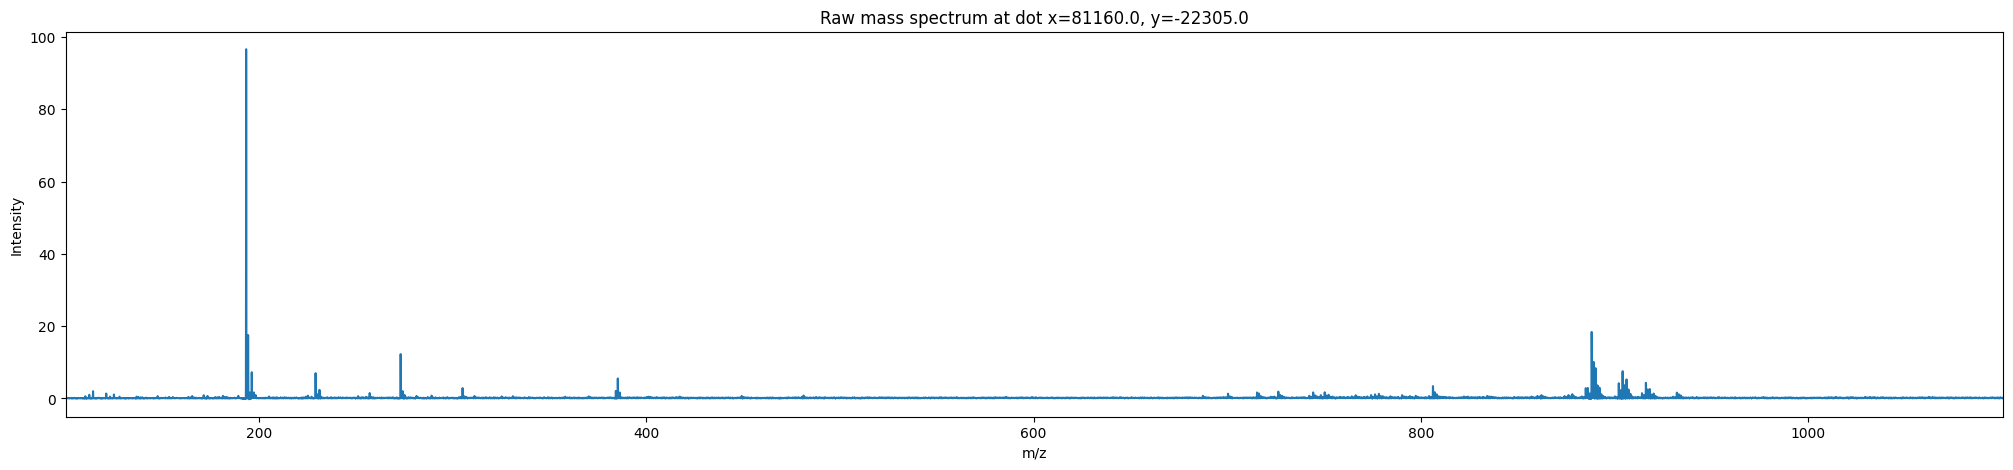

In [6]:
#Выгрузка датасета
int_array_full = data['Rapiflex']['roi8_e040']['00']['int'][:]
print(f"Intensity array shape: {int_array_full.shape}")
spectra_mz = data['Rapiflex']['roi8_e040']['00']['mz'][:] #являются общими для всех для континуальных данных
print(f"mz array shape: {spectra_mz.shape}")
spectra_coords_full = data['Rapiflex']['roi8_e040']['00']['xy'][:]
print(f"Coordinates array shape: {spectra_coords_full.shape}")

#Выгрузим интенсивности масс-спектра из одной точки с его координатами 
spectrum_int = data['Rapiflex']['roi8_e040']['00']['int'][4242,:]
spectrum_coords = data['Rapiflex']['roi8_e040']['00']['xy'][4242,:]

#Построим масс-спектр
plt.figure(figsize=(25,5))
plt.plot(spectra_mz,spectrum_int)
plt.title(f'Raw mass spectrum at dot x={spectrum_coords[0]}, y={spectrum_coords[1]}')
plt.ylabel('Intensity')
plt.xlabel('m/z')
plt.xlim((min(spectra_mz),max(spectra_mz)))
plt.show()

In [7]:
#Также можно выгрузить пиклисты
peaklists = data['Rapiflex']['roi8_e040']['00']['peaklists'][:]
print(peaklists)
print(peaklists.shape)
#Порядок столбцов
print(data['Rapiflex']['roi8_e040']['00']['peaklists'].attrs['Column headers'])

[[0.00000000e+00 1.12105202e+02 2.71684051e+00 ... 1.12156563e+02
  5.88236563e-02 1.29609734e-01]
 [0.00000000e+00 1.14067200e+02 5.84780645e+00 ... 1.14115845e+02
  5.88236563e-02 1.29609734e-01]
 [0.00000000e+00 1.17010185e+02 6.40537143e-01 ... 1.17065781e+02
  5.88236563e-02 1.29609734e-01]
 ...
 [2.11570000e+04 4.49207886e+02 8.46918941e-01 ... 4.49279144e+02
  5.97910844e-02 1.26899540e-01]
 [2.11570000e+04 4.81200378e+02 9.01554585e-01 ... 4.81268921e+02
  5.97910844e-02 1.26899540e-01]
 [2.11570000e+04 6.65367554e+02 6.92547977e-01 ... 6.65444275e+02
  5.97910844e-02 1.26899540e-01]]
(2213153, 11)
['spectra_ind' 'mz' 'Intensity' 'Area' 'SNR' 'PextL' 'PextR' 'FWHML'
 'FWHMR' 'Noise' 'Mean noise']


Где:
- `spectra_ind` - это индекс спектра, 
- `Area` - площадь пика
- `PextL` и `PextR`, левое и правое основание пиков, 
- а `FWHML` и `FWHMR` - левое и правое положение ширины на полувысоте.
- `Noise` - это шум, посчитанный (либо `std`, либо `mad`) по шумовым точкам спектра упрощённой функцией (для оптимизации) сразу по всему спектру.
- `Mean noise` - То же, что и `Noise`, только посчитан функцией `mean`

### Загрузка пиклистов функцией `peakl2DF`
Вариант выгрузки пиклиста выше неудобен для работы. Более комфортный вариант для работы - это использование DataFrame от pandas.

Для этого есть функция `peakl2DF` в модуле `loaders`, которая выгружает пиклисты и преобразует в удобный формат для дальнейшей работы.

Пример пути к датасету: HDF5File[Slide][sample][roi][dataset], 

- где `Slide` - это группа датасетов из одного hdf5 файла.

- `sample` - это группа данных, в которую выгружены данные из одного imzml файла (название sample создаётся следующим образом: <_название корневой папки imzml_>_<_название файла imzml_>, если <_название корневой папки imzml_> идентично <_название файла imzml_>, то sample записывается без дублированного названия и '\_' между)

- `roi` - это группа данных, отвечающая за область измерения. В одном файле imzml может быть записано несколько областей с одного эксперимента (к примеру файлы от Rapiflex). Но для остальных приборов в основном там только одна область: "00"

- `dataset` - название записанных данных:
    - `xy` - матрица координат (M,2), где каждая строка соответствует координатам спектра. 1-ая и 2-ая колонки - x и y координаты, соответственно.
    - `peaklists` - пиклист, где каждая строка - это характеристики одного пика из определённого спектра.

Индексация датасета согласно формату pandas DataFrame. Например:
* Выгрузить весь датасет: 
HDF5File[Slide][sample][roi][dataset]
* Выгрузить часть датасета:

    HDF5File[Slide][sample][roi][dataset].query('(mz>500) and (mz<900)')

    или эквивалентное (быстрее, но менее читаемое):
 
    HDF5File[Slide][sample][roi][dataset].loc[(HDF5File[Slide][sample][roi][dataset]["mz"]>500) & (HDF5File[Slide][sample][roi][dataset]["mz"]<900),:]

##### Параметры функции `peakl2DF`:
- `batch_path` - путь к папке/файлу `hdf5`. Возможно задать сразу несколько путей списком: [path_1, path_2].
    - Если нужно работать только с одним файлом в указанном пути, то лучше указать прямой путь к нему (example: *r"D:\Testing\Our_data\Rapiflex\Rapiflex_specdata.hdf5"*).
    - Если необходимо выгрузить сразу несколько файлов, указав один путь, то можно указать путь к общей папке (example: *r"D:\Testing\Our_data\"*).
- `extr_columns` - какие именно столбцы выгружать. 
    - Если `None` (Default), то выгружает все столбцы
    - если лист целых чисел, то выгружает следующие столбцы, соответствующие цифрам: 
        - 2 - `"Intensity"`, 
        - 3 -`"Area"`, 
        - 4 - `"SNR"`, 
        - 5 - `"PextL"`, 
        - 6 - `"PextR"`, -
        - 7 - `"FWHML"`, 
        - 8 - `"FWHMR"`, 
        - 9 -`"Noise"`, 
        - 10 -`"Mean noise"`

- `extract_coords` - Если `True`(default), то выгружает координаты масс-спектров имаджа.

##### Example:

In [8]:
from ProcceMSI.loaders import peakl2DF, hdf5_close

path = r"D:\Testing\Our_data\Rapiflex"
ftable = peakl2DF(path,extr_columns=[2,3,4])

# Выгрузим пиклист
display("Peaklist",ftable['Rapiflex']['roi8_e040']['00']['peaklists'])
# Выгрузим координаты спектров
display("Coordinates", ftable['Rapiflex']['roi8_e040']['00']['xy'])


Rapiflex, roi8_e040 and roi 00. x and y coordinates were extracted


'Peaklist'

,spectra_ind,mz,Intensity,Area,SNR
0,0,112.105202,2.716841,0.310637,46.186188
1,0,114.067200,5.847806,0.700600,99.412498
2,0,117.010185,0.640537,0.088922,10.889108
3,0,127.721077,0.769314,0.115008,13.078304
4,0,137.611130,0.693459,0.094206,11.788770
...,...,...,...,...,...
2213148,21157,401.199066,0.820583,0.172889,13.724172
2213149,21157,417.215393,0.656918,0.162786,10.986883
2213150,21157,449.207886,0.846919,0.144977,14.164636
2213151,21157,481.200378,0.901555,0.152523,15.078412


'Coordinates'

,x,y
spectra_ind,,
0,79580.0,-21525.0
1,79600.0,-21525.0
2,79620.0,-21525.0
3,79640.0,-21525.0
4,79660.0,-21525.0
...,...,...
21153,80680.0,-24325.0
21154,80700.0,-24325.0
21155,80720.0,-24325.0


### Запись пиклистов в другой формат данных
Для записи пиклистов в другой формат можно использовать методы класса [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

##### Example

In [9]:
ftable['Rapiflex']['roi8_e040']['00']['peaklists'].to_csv(r"D:\Testing\Our_data\Rapiflex\roi8_e040_peaklist.csv",)

<div class="alert alert-block alert-warning">
В масс-спектрах в имадже, даже после выравнивания, пики немного отличаются по абсолютным значениям и для дальнейшей работы с ними требуется пики сгруппировать.</div>